In [1]:
%matplotlib inline
import utils; import importlib; importlib.reload(utils)
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [3]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [6]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [8]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [12]:
n_factors = 50

In [13]:
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [76]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [78]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [80]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [81]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [82]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [67]:
from keras import regularizers
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=regularizers.l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=regularizers.l2(1e-4))(movie_in)

In [91]:
from keras.layers import dot
x = dot([u, m], axes=2)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [92]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/1
80244/80244 [==============================] - 4s 47us/step - loss: 4.2920 - val_loss: 3.3442


In [93]:
model.optimizer.lr=0.01

In [94]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/3
80244/80244 [==============================] - 5s 60us/step - loss: 2.7676 - val_loss: 2.7287
Epoch 2/3
80244/80244 [==============================] - 5s 57us/step - loss: 2.3585 - val_loss: 2.5914
Epoch 3/3
80244/80244 [==============================] - 4s 53us/step - loss: 2.2355 - val_loss: 2.5651


In [95]:
model.optimizer.lr=0.001

In [96]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/6
80244/80244 [==============================] - 4s 53us/step - loss: 2.1913 - val_loss: 2.5619
Epoch 2/6
80244/80244 [==============================] - 5s 57us/step - loss: 2.1657 - val_loss: 2.5570
Epoch 3/6
80244/80244 [==============================] - 5s 58us/step - loss: 2.1442 - val_loss: 2.5514
Epoch 4/6
80244/80244 [==============================] - 4s 54us/step - loss: 2.1208 - val_loss: 2.5528
Epoch 5/6
80244/80244 [==============================] - 5s 56us/step - loss: 2.0949 - val_loss: 2.5601
Epoch 6/6
80244/80244 [==============================] - 5s 58us/step - loss: 2.0715 - val_loss: 2.5694


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [97]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=regularizers.l2(reg))(inp)

In [98]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [99]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [100]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [104]:
from keras.layers import dot, add
x = dot([u, m], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [105]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/1
80244/80244 [==============================] - 4s 53us/step - loss: 3.2727 - val_loss: 2.4951


In [106]:
model.optimizer.lr=0.01

In [107]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/6
80244/80244 [==============================] - 4s 47us/step - loss: 2.0952 - val_loss: 2.0506
Epoch 2/6
80244/80244 [==============================] - 4s 55us/step - loss: 1.8139 - val_loss: 1.9170
Epoch 3/6
80244/80244 [==============================] - 4s 51us/step - loss: 1.6985 - val_loss: 1.8423
Epoch 4/6
80244/80244 [==============================] - 5s 58us/step - loss: 1.6188 - val_loss: 1.7733
Epoch 5/6
80244/80244 [==============================] - 4s 46us/step - loss: 1.5435 - val_loss: 1.7095
Epoch 6/6
80244/80244 [==============================] - 4s 45us/step - loss: 1.4690 - val_loss: 1.6460


In [108]:
model.optimizer.lr=0.001

In [109]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/10
80244/80244 [==============================] - 4s 46us/step - loss: 1.3957 - val_loss: 1.5874
Epoch 2/10
80244/80244 [==============================] - 4s 45us/step - loss: 1.3268 - val_loss: 1.5320
Epoch 3/10
80244/80244 [==============================] - 4s 44us/step - loss: 1.2603 - val_loss: 1.4824
Epoch 4/10
80244/80244 [==============================] - 4s 44us/step - loss: 1.1978 - val_loss: 1.4369
Epoch 5/10
80244/80244 [==============================] - 3s 43us/step - loss: 1.1380 - val_loss: 1.3893
Epoch 6/10
80244/80244 [==============================] - 4s 51us/step - loss: 1.0810 - val_loss: 1.3474
Epoch 7/10
80244/80244 [==============================] - 4s 51us/step - loss: 1.0266 - val_loss: 1.3092
Epoch 8/10
80244/80244 [==============================] - 4s 49us/step - loss: 0.9761 - val_loss: 1.2728
Epoch 9/10
80244/80244 [==============================] - 4s 44us/step - loss: 0.9287 - val_loss: 1.2406
Epoch

In [110]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/5
80244/80244 [==============================] - 4s 46us/step - loss: 0.8431 - val_loss: 1.1811
Epoch 2/5
80244/80244 [==============================] - 4s 44us/step - loss: 0.8048 - val_loss: 1.1546
Epoch 3/5
80244/80244 [==============================] - 4s 44us/step - loss: 0.7702 - val_loss: 1.1326
Epoch 4/5
80244/80244 [==============================] - 3s 41us/step - loss: 0.7383 - val_loss: 1.1136
Epoch 5/5
80244/80244 [==============================] - 3s 43us/step - loss: 0.7099 - val_loss: 1.0937


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [111]:
model.save_weights(model_path+'bias.h5')

In [112]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [113]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.9554]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [44]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [45]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [46]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.86539066, 'Blade: Trinity (2004)'),
 (-0.81603444, 'Battlefield Earth (2000)'),
 (-0.6496526, 'House on Haunted Hill (1999)'),
 (-0.54121006, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.50123268, 'Jaws 3-D (1983)'),
 (-0.44859841, 'Speed 2: Cruise Control (1997)'),
 (-0.35156989, 'Super Mario Bros. (1993)'),
 (-0.32474193, 'Bio-Dome (1996)'),
 (-0.28154615, 'Howard the Duck (1986)'),
 (-0.26755497, 'Wild Wild West (1999)'),
 (-0.26024514, 'Police Academy 6: City Under Siege (1989)'),
 (-0.25325182, 'Spice World (1997)'),
 (-0.23534949, 'Batman & Robin (1997)'),
 (-0.20432301, 'Vampire in Brooklyn (1995)'),
 (-0.18147577, 'Lost in Space (1998)')]

In [47]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.7744172, 'Shawshank Redemption, The (1994)'),
 (1.7470362, 'Tom Jones (1963)'),
 (1.7195621, 'African Queen, The (1951)'),
 (1.7122966, 'Wings of Desire (Himmel über Berlin, Der) (1987)'),
 (1.6818608, 'General, The (1926)'),
 (1.6684693, 'Grand Day Out with Wallace and Gromit, A (1989)'),
 (1.6599189, 'Godfather, The (1972)'),
 (1.6587247, '3:10 to Yuma (2007)'),
 (1.6502813, 'Rush (2013)'),
 (1.6438258, 'The Imitation Game (2014)'),
 (1.635447, 'It Happened One Night (1934)'),
 (1.61989, 'Mister Roberts (1955)'),
 (1.6182964, 'Treasure of the Sierra Madre, The (1948)'),
 (1.6123681, 'Memphis Belle (1990)'),
 (1.6117163, 'On the Waterfront (1954)')]

We can now do the same thing for the embeddings.

In [48]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [50]:
fac0 = movie_pca[0]

In [51]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.086641192, 'Kill Bill: Vol. 1 (2003)'),
 (0.085001446, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.084541932, 'American Beauty (1999)'),
 (0.084129304, 'Godfather, The (1972)'),
 (0.081894062, '2001: A Space Odyssey (1968)'),
 (0.077283695, 'Blade Runner (1982)'),
 (0.076745793, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.073723167, 'Wallace & Gromit: A Close Shave (1995)'),
 (0.07250084, 'Citizen Kane (1941)'),
 (0.070956528, 'Pulp Fiction (1994)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.073490582, 'Stargate (1994)'),
 (-0.072350249, 'Armageddon (1998)'),
 (-0.06432002, 'Anaconda (1997)'),
 (-0.05686805, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.04759964, 'Lethal Weapon 4 (1998)'),
 (-0.047167968, 'Net, The (1995)'),
 (-0.046721086, 'Batman Forever (1995)'),
 (-0.046701062, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.046131138, 'Down Periscope (1996)'),
 (-0.0458293, 'Lost World: Jurassic Park, The (1997)')]

In [54]:
fac1 = movie_pca[1]

In [55]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.059263371, 'Manhattan (1979)'),
 (0.058688078, 'Annie Hall (1977)'),
 (0.055498686, 'Lost Highway (1997)'),
 (0.048185419, 'Big Lebowski, The (1998)'),
 (0.047884099, 'Bringing Up Baby (1938)'),
 (0.047160055, 'American Psycho (2000)'),
 (0.046212543, 'Brokeback Mountain (2005)'),
 (0.045605354, 'Vertigo (1958)'),
 (0.040813129, 'Blue Velvet (1986)'),
 (0.040426329, 'Clockwork Orange, A (1971)')]

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11249222, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.11161005, 'Titanic (1997)'),
 (-0.10406405, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.10243256, 'Saving Private Ryan (1998)'),
 (-0.10134018, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.099675976, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.098365195, 'Braveheart (1995)'),
 (-0.094501235, 'Jurassic Park (1993)'),
 (-0.092089027, 'Spider-Man (2002)'),
 (-0.091182657, 'Gladiator (2000)')]

In [58]:
fac2 = movie_pca[2]

In [59]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [60]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.097835936, 'Beauty and the Beast (1991)'),
 (0.09324684, 'Babe (1995)'),
 (0.081848644, 'Sound of Music, The (1965)'),
 (0.070660345, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.070628166, 'Finding Nemo (2003)'),
 (0.069983445, 'Life Is Beautiful (La Vita è bella) (1997)'),
 (0.069709904, 'Superman II (1980)'),
 (0.069022447, 'Legally Blonde (2001)'),
 (0.068760425, 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (0.068660274, 'Little Mermaid, The (1989)')]

In [61]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.12086629, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.10053171, 'Fight Club (1999)'),
 (-0.092812389, 'Silence of the Lambs, The (1991)'),
 (-0.087040789, 'Pulp Fiction (1994)'),
 (-0.082367823, 'American Psycho (2000)'),
 (-0.074273743, 'True Lies (1994)'),
 (-0.072709925, 'Stargate (1994)'),
 (-0.071834654, 'Die Hard: With a Vengeance (1995)'),
 (-0.071737409, 'Clockwork Orange, A (1971)'),
 (-0.070946567, 'Lord of the Rings: The Two Towers, The (2002)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [62]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

NameError: name 'reload' is not defined

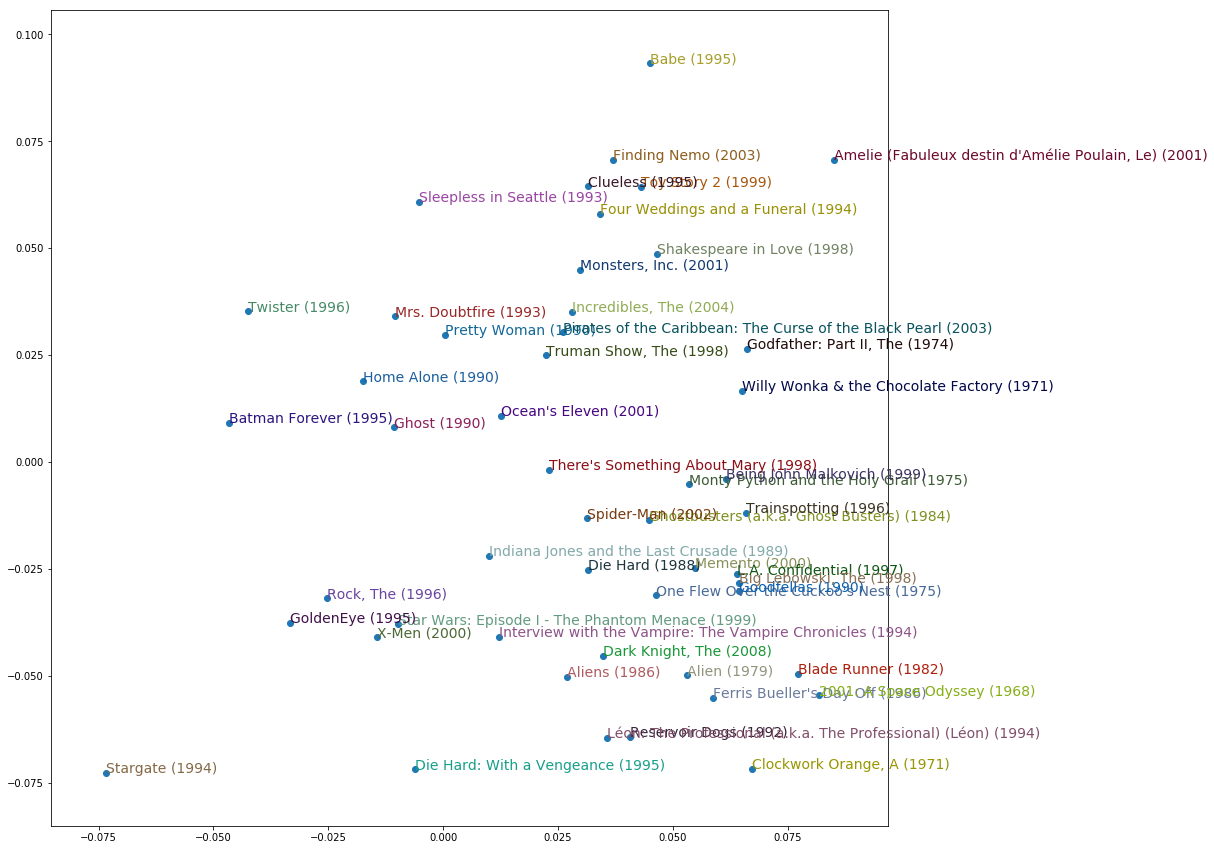

In [63]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [114]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [119]:
from keras.layers import concatenate
x = concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [120]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80244 samples, validate on 19760 samples
Epoch 1/8
80244/80244 [==============================] - 5s 57us/step - loss: 2.4257 - val_loss: 0.9085
Epoch 2/8
80244/80244 [==============================] - 4s 48us/step - loss: 1.4549 - val_loss: 0.8820
Epoch 3/8
80244/80244 [==============================] - 4s 51us/step - loss: 1.2222 - val_loss: 0.8671
Epoch 4/8
80244/80244 [==============================] - 4s 46us/step - loss: 1.0293 - val_loss: 0.8602
Epoch 5/8
80244/80244 [==============================] - 4s 51us/step - loss: 0.9173 - val_loss: 0.8364
Epoch 6/8
80244/80244 [==============================] - 4s 51us/step - loss: 0.8480 - val_loss: 0.8302
Epoch 7/8
80244/80244 [==============================] - 4s 51us/step - loss: 0.8211 - val_loss: 0.8270
Epoch 8/8
80244/80244 [==============================] - 4s 53us/step - loss: 0.8119 - val_loss: 0.8317


This improves on our already impressive accuracy even further!